In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

In [ ]:
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(tr_dir, val_dir, ts_dir):
    # train dataframe
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)

    # validation dataframe
    files, classes = define_paths(val_dir)
    valid_df = define_df(files, classes)
    # test dataframe
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df

In [ ]:
import cv2
import numpy as np
def preprocessing_function(img):
    # Ensure image is in the right format
    img = img.astype(np.uint8)

    # Check if the image has a single channel, convert to 3 channels if necessary
    if len(img.shape) == 2 or img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Convert image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Enhance image using histogram equalization
    enhanced_img = cv2.equalizeHist(gray_img)

    # Apply thresholding
    _, segmentedImage = cv2.threshold(enhanced_img, 128, 255, cv2.THRESH_TOZERO)

    # Convert back to 3-channel image
    segmentedImage = cv2.cvtColor(segmentedImage, cv2.COLOR_GRAY2BGR)

    return segmentedImage

In [ ]:
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
    test_batch_size = 16
    test_steps = ts_length // test_batch_size
    def scalar(img):
        return img
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)
    return train_gen, valid_gen, test_gen

In [ ]:
def show_images(gen):
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's keys (classes)
    images, labels = next(gen)        # get a batch size samples from the generator
    plt.figure(figsize=(20, 20))
    length = len(labels)              # length of batch size

    for i in range(min(5, length)):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i] / 255)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name)
        plt.axis('off')
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
train_path_str = 'drive/MyDrive/Data/Data/train'
val_path_str = 'drive/MyDrive/Data/Data/Data/valid'
test_path_str = 'drive/MyDrive/Data/Data/Data/test'


Found 566 validated image filenames belonging to 2 classes.
Found 63 validated image filenames belonging to 2 classes.
Found 280 validated image filenames belonging to 2 classes.


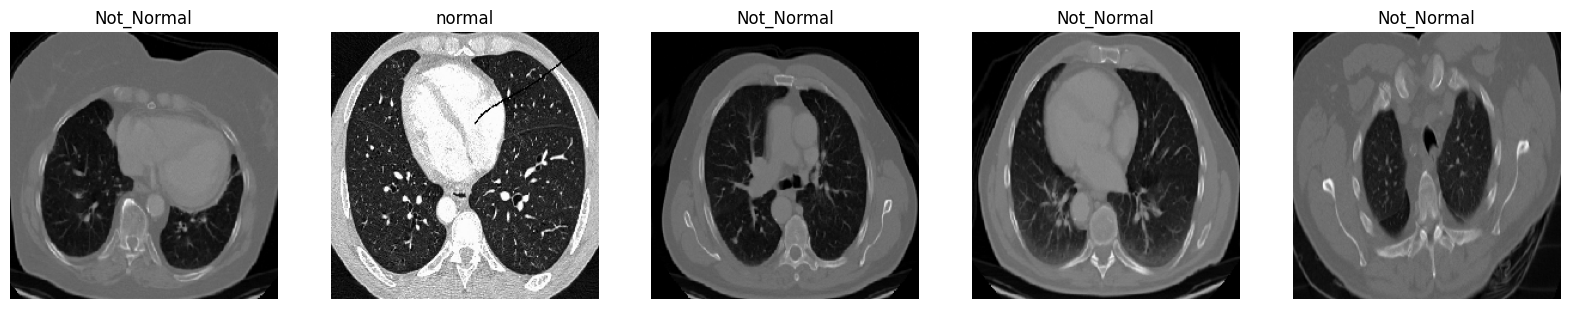

In [ ]:
import numpy as np
train_path_str = 'drive/MyDrive/Data/Data/train'
val_path_str = 'drive/MyDrive/Data/Data/valid'
test_path_str = 'drive/MyDrive/Data/Data/test'

train_df, valid_df, test_df = create_df(train_path_str, val_path_str, test_path_str)

# Create generators
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, 10)

# Show images from the training generator
show_images(train_gen)

In [ ]:
from keras.applications import  VGG16


In [ ]:
input_shape = (224, 224, 3)
modelVGG16 = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = input_shape)

for layer in modelVGG16.layers:
    layer.trainable = False



58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping


adam = Adam(learning_rate = 0.0001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 5, mode = 'max', verbose = 1)
path = 'best_model.h5'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath = path, monitor = 'val_accuracy', mode = 'max', save_best_only = True, verbose = 1)
# Train the model with the added callback
history = model.fit(train_gen, validation_data = valid_gen, epochs = 20, callbacks = [early_stopping, checkpoint])

In [ ]:
best_model = load_model(path)


In [ ]:
loss, acc = best_model.evaluate(test_gen)

print(f'\nAccuracy = {acc}\nLoss = {loss}')

In [ ]:
plt.plot(history.history['accuracy'], label = 'Train accuracy')
plt.plot(history.history['val_accuracy'], label = 'val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')

In [ ]:
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 'best')

In [ ]:
model.save('final_ensemble_model.h5')


In [ ]:
pred = model.predict(test_gen)
pred = np.argmax(pred, axis=1) #pick class with highest  probability



In [ ]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')


target_names = ['Not_Normal', 'normal']
# Confusion matrix
cm = confusion_matrix(test_gen.classes, pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(test_gen.classes, pred, target_names= target_names))